In [118]:
# !pip install tf-agents

In [119]:
from __future__ import absolute_import, division, print_function

# Packages to support visualization
import base64
import imageio
import IPython
import PIL.Image
import pyvirtualdisplay
import matplotlib
import matplotlib.pyplot as plt

# Packages to support model training
import numpy as np
import tensorflow as tf
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

In [122]:
# Declare model constants
num_iterations = 30000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
actor_learning_rate = 1e-3
critic_learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 10
eval_interval = 1000
episode_steps = 100

In [123]:
class ControlSysEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.float32, minimum=-1, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(2,), dtype=np.float32, minimum=np.array([-2,-2]), maximum=np.array([2,2]), name='observation')
        self._state = np.float32(2.0*np.random.rand(2) - 1.0) # np.array([1.0, 1.0], dtype=np.float32)
        self._step_counter = 0 
        self._episode_ended = False
        self._time_step_size = 0.1 # was 0.01, which was too small.
        # The control system dynamics. If you change A or B's shapes, change them in the spec too. 
        self._A = np.array([[0, 1], [0, 0]])
        self._B = np.array([0, 1]).T

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.float32(2.0*np.random.rand(2) - 1.0)
        self._step_counter = 0
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
    
        self._step_counter = self._step_counter + 1

        if self._episode_ended:
            return self.reset()
        else:
            self._state = np.array(self._state + self._time_step_size*(
                np.matmul(self._A, self._state.T) + self._B*action), dtype=np.float32)
            # Errors will be generated if the state exits the bounds of the observation spec
            for i in range(int(self.time_step_spec().observation.shape[0])):
                if self._state[i] > self.time_step_spec().observation.maximum[i]:
                    self._state[i] = self.time_step_spec().observation.maximum[i]
                elif self._state[i] < self.time_step_spec().observation.minimum[i]:
                    self._state[i] = self.time_step_spec().observation.minimum[i]
    
        if self._step_counter >= episode_steps:
            self._episode_ended = True
    
        reward = -1*(4*np.sum(np.power(self._state,2)) + 0.1*np.sum(np.power(action,2)))
    
        if self._episode_ended:
            return ts.termination(self._state, reward)
        else:
            return ts.transition(self._state, reward, discount=1.0)

In [124]:
# Initialize environment
# env_name = 'Pendulum-v0'
env = ControlSysEnv() # suite_gym.load(env_name)
train_py_env = ControlSysEnv() # suite_gym.load(env_name)
eval_py_env = ControlSysEnv() # suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Display environment dimensions
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
time_step = env.reset()
print('Time step:')
print(time_step)

Observation Spec:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-2. -2.], maximum=[2. 2.])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)
Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.1512351,  0.360709 ], dtype=float32))


In [125]:
# Create the agent's actor and critic networks
act_net = actor_network.ActorNetwork(input_tensor_spec = train_env.observation_spec(),
                                     output_tensor_spec = train_env.action_spec(),
                                     fc_layer_params = (400,300),
                                     activation_fn = tf.keras.activations.relu                 
                                     )

crit_net = critic_network.CriticNetwork(input_tensor_spec = (train_env.observation_spec(), train_env.action_spec()),
                                        observation_fc_layer_params = (400,),
                                        action_fc_layer_params = None,
                                        joint_fc_layer_params = (400,),
                                        activation_fn = tf.keras.activations.relu
                                        )

In [126]:
# Instantiate the agent and supply it with its actor and critic networks
actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate)
critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=critic_learning_rate)

train_step_counter = tf.Variable(0)

global_step = tf.Variable(0, trainable=False)
starter_epsilon = 1.0
end_epsilon = 0.5
decay_steps = num_iterations + initial_collect_steps
ou_noise_size = tf.compat.v1.train.polynomial_decay(starter_epsilon,
                                                    train_step_counter,
                                                    decay_steps,
                                                    end_epsilon,
                                                    power=1.0,
                                                    cycle=False)

agent = ddpg_agent.DdpgAgent(time_step_spec = train_env.time_step_spec(),
                             action_spec = train_env.action_spec(),
                             actor_network = act_net,
                             critic_network = crit_net,
                             actor_optimizer = actor_optimizer,
                             critic_optimizer = critic_optimizer, 
                             gamma = 0.99,
                             target_critic_network = None, # Target network = same type as primary
                             target_update_tau = 0.1, 
                             ou_stddev = ou_noise_size(), # was 1 
                             ou_damping = 0.25,
                             td_errors_loss_fn = common.element_wise_squared_loss,
                             train_step_counter=train_step_counter
                             )

agent.initialize()

In [127]:
# Declare the function that will measure the training progress of the agent
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [128]:
# Create the replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [129]:
# Create the function that performs the action on the environment and adds the data to the replay buffer
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

In [130]:
# Compute performance baseline using random actions
example_environment = tf_py_environment.TFPyEnvironment(ControlSysEnv())
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-1063.9883

In [131]:
# Peform functions required before entering the training loop
collect_data(train_env, random_policy, replay_buffer, steps=100)
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print(returns)

[-1084.487]


In [132]:
# Execute the main training loop
for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}, noise = {2}'.format(step, train_loss, float(np.round(np.array(ou_noise_size()),2))))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 98.38550567626953, noise = 1.0
step = 400: loss = 116.2972412109375, noise = 0.9900000095367432
step = 600: loss = 20360.37890625, noise = 0.9900000095367432
step = 800: loss = 8224.5322265625, noise = 0.9900000095367432
step = 1000: loss = 491.4618835449219, noise = 0.9800000190734863
step = 1000: Average Return = -66.92575073242188
step = 1200: loss = 378.8317565917969, noise = 0.9800000190734863
step = 1400: loss = 643.8397216796875, noise = 0.9800000190734863
step = 1600: loss = 4214.0859375, noise = 0.9700000286102295
step = 1800: loss = 481.689208984375, noise = 0.9700000286102295
step = 2000: loss = 2170.021728515625, noise = 0.9700000286102295
step = 2000: Average Return = -380.43328857421875
step = 2200: loss = 144.95266723632812, noise = 0.9599999785423279
step = 2400: loss = 426.8875732421875, noise = 0.9599999785423279
step = 2600: loss = 112.8019790649414, noise = 0.9599999785423279
step = 2800: loss = 179.16297912597656, noise = 0.949999988079071
step =

Text(0.5, 0, 'Iterations')

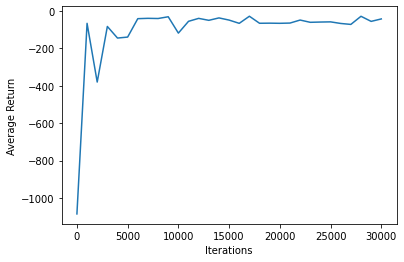

In [134]:
# Visualize the training progress of the agent
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

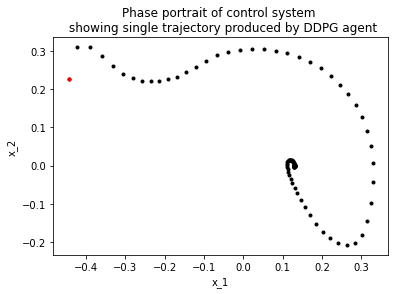

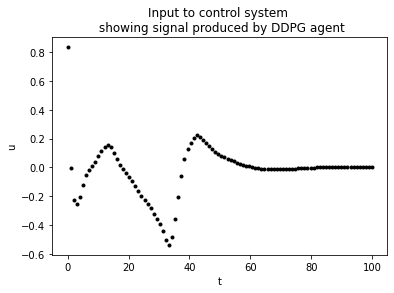

In [133]:
# Visualize the behaviour of the agent on one episode 
state_traj = np.zeros((episode_steps,
                       train_env.time_step_spec().observation.shape[0]))
action_signal = np.zeros(episode_steps)

train_env.reset()
for t in range(episode_steps):
    state_traj[t,:] = train_env.current_time_step().observation
    action_step = agent.policy.action(train_env.current_time_step())
    action_signal[t] = action_step.action
    train_env.step(action_step.action)
    
plt.figure()
plt.plot(state_traj[:,0], state_traj[:,1], '.k')
# Red dot shows initial state
plt.plot(state_traj[0,0], state_traj[0,1], '.r')
plt.title('Phase portrait of control system \n showing single trajectory '
          'produced by DDPG agent')
plt.xlabel('x_1')
plt.ylabel('x_2')

plt.figure()
plt.plot(np.linspace(0, episode_steps, episode_steps), action_signal, '.k')
plt.title('Input to control system \n showing signal '
          'produced by DDPG agent')
plt.xlabel('t')
plt.ylabel('u')

plt.show()

# Note: To get the optimal action at each state, intantiate a TimeStep object at the
# that state, then pass it to agent.policy.action(my_time_step)
# Use tf_agents.trajectories.time_step.TimeStep(step_type, reward, discount, observation)
# where observation contains the state.
# Ref at https://tensorflow.google.cn/agents/api_docs/python/tf_agents/trajectories/time_step/TimeStep 